# MNIST Classification

In this notebook, we'll explore the MNIST (Modified National Institute of Standards and Technology) database - a large set of handwritten digits with their associated labels.  A common Machine Learning challenge is to build a multiclass classifier than can tell with high accuracy what digit a given image represents.

In [1]:
# Import modules for maths, data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('default')

In [2]:
# Fetch and load data
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# Extract features and labels
data, labels = mnist["data"], mnist["target"].astype(np.uint8)

# Select three arbitrary digits
example_digits = data[40:43]

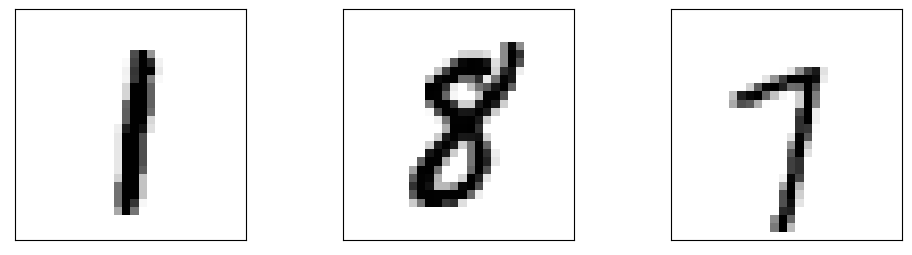

In [4]:
# Set up plotting area
fig = plt.figure(figsize=(12,3))

# Set up subplots for each digit - we'll plot each one side by side to illustrate the variation
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
axs = [ax1, ax2, ax3]

# Plot the digits
for i in range(3):
    
    ax = axs[i]
    ax.imshow(example_digits[i].reshape(28, 28), cmap="binary")
    ax.set_xticks([], []) 
    ax.set_yticks([], []) 

plt.show()

Before going any further, let's split the data into training and test sets.  Then we can explore the training set all we like without risking becoming biased and giving ourselves an unfair advantage when we eventually come to evaluate the performance of our model on the test set.

In [5]:
data_train, data_test, labels_train, labels_test = data[:60000], data[60000:], labels[:60000], labels[60000:]

As a first step, let's simplify the classification problem and build a binary classifier.  Let's see if we can train a model to recognise 7's.  The two possible outcomes for this scenario are then simply *7* and *not 7*.

In [6]:
labels_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [7]:
labels_train_7 = (labels_train == 7) # True for 7's, false for all other digits
labels_test_7 = (labels_test == 7)

Now let's select and train a classifier.  A good place to start is with a *Stochastic Gradient Descent* (SGD) classifier as they can handle large datasets efficiently.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf_7 = SGDClassifier(random_state=0) # Instantiate model
sgd_clf_7.fit(data_train, labels_train_7) # Train to recognise 7's

SGDClassifier(random_state=0)

Evaluate the model on our three example digits from earlier:

In [9]:
sgd_clf_7.predict(example_digits)

array([False, False,  True])

How delightful - our classifier has got it right.  Now, let's see how it does when we cross-validate the model:

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf_7, data_train, labels_train_7, cv=3, scoring="accuracy")

array([0.9754 , 0.9795 , 0.98115])

Not too shabby!  Our classifer scores at least 96% accuracy in distinguishing sevens from not-sevens.  But wait - is this really so impressive?  Let's construct the stupidest model we can - one that always guesses that the digit isn't a seven.  There are a lot of not-sevens in the dataset, so it might end up doing quite well despite its lack of intelligence.

In [11]:
from sklearn.base import BaseEstimator

class AlwaysNot7(BaseEstimator):
    
    def fit(self, X, y=None):
        return self # Fitting does nothing
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # Return an array made up of one False per instance of data

always_not_7_clf = AlwaysNot7()

cross_val_score(always_not_7_clf, data_train, labels_train_7, cv=3, scoring="accuracy")

array([0.89535, 0.8984 , 0.893  ])

Our dumb model scores 89% accuracy!  We're still significantly more accurate when we actually train our model, but this exercise just shows that model performance is relative and needs to be compared to a suitable baseline to properly evaluate it.

Now, instead of just coming up with the cross validation accuracy scores, let's actually get a set of predictions.  We can use cross_val_predict to get a "clean" set of predictions on the training data - ie predictions for each instance in the training data are obtained by training the model on a set of folds *which do not contain the instance being predicted.*  In this way, we ensure that the model can't cheat by seeing the answer before making a prediction!

In [12]:
from sklearn.model_selection import cross_val_predict

data_train_predictions = cross_val_predict(sgd_clf_7, data_train, labels_train_7, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix

conf_mx_7 = confusion_matrix(labels_train_7, data_train_predictions)
conf_mx_7

array([[53321,   414],
       [  865,  5400]], dtype=int64)

We get the following results:
- 53,321 True Positives (model predicted 7, was actually a 7);
- 414 False Negatives (model predicted not-7, was actually a 7);
- 865 False Positives (model predicted 7, was actually not a 7); and
- 5400 True Negatives (model predicted not-7, was actually not a 7).

*Precision* is the ratio of True Positives to positive predictions, ie TP / (TP + FP).  Precision represents how reliable the model's positive predictions are.  

*Recall* is the ratio of True Positives to all positive instances in the dataset, ie TP / (TP + FN).  Recall represents how good the model is at catching positive instances.  

The mathematics of calculating precision and recall is not particularly demanding for this example, but nonetheless, they can easily be calculated as follows:

In [14]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(labels_train_7, data_train_predictions))
print(recall_score(labels_train_7, data_train_predictions))

0.9287925696594427
0.8619313647246608


Our model thus has around 93% precision and 86% recall.  The precision and recall are often combined into a single metric for convenience—the F1 score.  It's calculated as the harmonic mean of the precision and recall (this means that we will only get a high F1 score if both the precision and recall are high.  If either one is low, then it will drag the average down significantly).

In [15]:
from sklearn.metrics import f1_score

print(f1_score(labels_train_7, data_train_predictions))

0.8941137511383392


As both our precision and recall are pretty high, the F1 score is also quite good.  On the whole, our model isn't half bad at identifying sevens.  Perhaps it would struggle with more ambiguous numbers, though—the only digit that is vagualy similar to 7 is 1.  

Our SGD classifier makes decisions by calculating a *decision score* for each instance.  If the decision score for a given instance is above a particular value, then that instance is predicted to be a positive result—otherwise it is classified as negative.  If we were able to increase the threshold, then the model would give more negative predictions and would only give predictions for the instances that it was more sure about (which would have higher decision scores).

We cannot set the threshold of our SGD classifier directly, but we can access the decision scores that the model produces for a given set of data.  We can then set our own threshold, compare it with the decision scores, and infer what the model would have throught if it had used that threshold.  We can get decision scores using cross_val_predict with the method parameter set to "decision_function".

In [16]:
data_train_decision_scores = cross_val_predict(sgd_clf_7, data_train, labels_train_7, cv=3,
                                                method="decision_function")

In [17]:
threshold = 0

print(sum(data_train_decision_scores > threshold))

threshold = 1000 # Require model to be more confident to classify as positive by raising decision score threshold

print(sum(data_train_decision_scores > threshold))

5814
5542


Raising the threshold reduces the number of positive predictions.  However, this will typically mean that there are now more false negatives—positive instances that the model would have correctly identified if it was allowed to be less prudent with its estimates.  

We can plot how the precision and recall vary with the threshold.  By doing this, we can select a threshold that gives us an acceptable balance of precision and recall.  Whether we require high precision, high recall, or indeed both, depends on the particular situation in which the model will be applied.  In some circumstances, high recall may be preferred over high precision if there is little cost associated with a few false alarms (false positives) but high costs associated with missing a positive instance (false negatives).